## COMP338 ASS2



### Import package

In [21]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from sklearn.metrics import classification_report
import numpy as np

### Test Cuda Cores availability and set device if cuda is available

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device using: ', device)

Device using:  cuda


### MiniVGGNet with Dropout 

Use resource from when build the function: https://pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/
                                           https://github.com/khanhnamle1994/fashion-mnist/blob/master/CNN-4Conv.ipynb
                                           https://github.com/matvi/miniVGGNet


In [23]:
class MiniVGGNet(nn.Module):
    def __init__(self, inputShape, classes):
        super(MiniVGGNet, self).__init__()

        # Initialize the channel dimension, this will be used for batch normalization.
        chanDim = 1 if inputShape[0] == 1 else 3

        # First set of CONV => RELU => CONV => RELU => POOL layers
        # This set of layers has 32 filters and uses 'same' padding to preserve spatial dimensions.
        self.conv1a = nn.Conv2d(inputShape[0], 32, (3, 3), padding="same")
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, (3, 3), padding="same")
        self.bn1b = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Pooling to reduce spatial dimensions
        self.dropout1 = nn.Dropout(0.25)  # Dropout for regularization

        # Second set of CONV => RELU => CONV => RELU => POOL layers
        # Increasing the number of filters to 64 for deeper feature extraction.
        self.conv2a = nn.Conv2d(32, 64, (3, 3), padding="same")
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, (3, 3), padding="same")
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # Further reducing dimensions
        self.dropout2 = nn.Dropout(0.25)  # Additional dropout

        # First (and only) set of FC => RELU layers
        # The feature map is flattened and fed into fully connected layers.
        self.fc1 = nn.Linear(64 * (inputShape[1] // 4) * (inputShape[2] // 4), 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)  # Dropout to prevent overfitting

        # Final softmax classifier that outputs probability distributions over the classes.
        self.fc2 = nn.Linear(512, classes)

    def forward(self, x):
        # Applying the first set of layers followed by activation, batch normalization, and pooling
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Applying the second set of layers with the same pattern as above
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten the convolutional layer's output to feed it into the fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)

        # Output layer with a softmax to obtain probabilities for each class
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


### MiniVGGNet without Dropout 

In [24]:
# class MiniVGGNet(nn.Module):
#     def __init__(self, inputShape, classes):
#         super(MiniVGGNet, self).__init__()
# 
#         # Initialize the channel dimension for batch normalization
#         chanDim = 1 if inputShape[0] == 1 else 3
# 
#         # First set of CONV => RELU => CONV => RELU => POOL layers
#         self.conv1a = nn.Conv2d(inputShape[0], 32, (3, 3), padding="same")
#         self.bn1a = nn.BatchNorm2d(32)
#         self.conv1b = nn.Conv2d(32, 32, (3, 3), padding="same")
#         self.bn1b = nn.BatchNorm2d(32)
#         self.pool1 = nn.MaxPool2d(kernel_size=2)  # Pooling to reduce spatial dimensions
# 
#         # Second set of CONV => RELU => CONV => RELU => POOL layers
#         self.conv2a = nn.Conv2d(32, 64, (3, 3), padding="same")
#         self.bn2a = nn.BatchNorm2d(64)
#         self.conv2b = nn.Conv2d(64, 64, (3, 3), padding="same")
#         self.bn2b = nn.BatchNorm2d(64)
#         self.pool2 = nn.MaxPool2d(kernel_size=2)  # Further reducing dimensions
# 
#         # Fully connected layers
#         self.fc1 = nn.Linear(64 * (inputShape[1] // 4) * (inputShape[2] // 4), 512)
#         self.bn_fc1 = nn.BatchNorm1d(512)
# 
#         # Final softmax classifier
#         self.fc2 = nn.Linear(512, classes)
# 
#     def forward(self, x):
#         # Applying the first set of layers followed by activation, batch normalization, and pooling
#         x = F.relu(self.bn1a(self.conv1a(x)))
#         x = F.relu(self.bn1b(self.conv1b(x)))
#         x = self.pool1(x)
# 
#         # Applying the second set of layers
#         x = F.relu(self.bn2a(self.conv2a(x)))
#         x = F.relu(self.bn2b(self.conv2b(x)))
#         x = self.pool2(x)
# 
#         # Flatten the output and apply the fully connected layers
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.bn_fc1(self.fc1(x)))
# 
#         # Output layer with a softmax
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

### Functions for Data Loading, Training, Testing, and Plotting

In [42]:
def load_data_and_transform(train_batch_size, test_batch_size):
    # Define a transformation pipeline to preprocess the images
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to PyTorch tensor format
        transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean 0.5 and standard deviation 0.5
    ])

    # Load the FashionMNIST training dataset with transformations
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    # Create a DataLoader 
    train_loader_f = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

    # Load the FashionMNIST test dataset with transformations
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    # Create a DataLoader for the test dataset 
    test_loader_f = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    return train_loader_f, test_loader_f


# This function is for calculating the accuracy and loss on TEST SET when TRAINING the model
def calculate_loss_and_accuracy(model_f, data_loader):
    # Set model to evaluation mode and initialize metrics
    model_f.eval()
    loss, correct, total = 0, 0, 0

    with torch.no_grad():  # No gradient computation for evaluation
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model_f(data)
            loss += loss_function(output, target).item()  # Accumulate loss
            pred = output.argmax(dim=1, keepdim=True)  # Get predicted class
            correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions
            total += target.size(0)
    # Calculate average loss and accuracy
    loss /= len(data_loader)
    accuracy = 100. * correct / total

    return loss, accuracy


def train_model(model_f, train_loader_f, test_loader_f, epochs_f):
    for epoch in epochs_f:
        model_f.train()  # Set the model to training mode
        train_loss = 0  # Initialize the loss for this epoch

        # Iterate over the training data
        with tqdm(train_loader_f, unit="batch") as tqdm_epoch:
            for data, target in tqdm_epoch:
                tqdm_epoch.set_description(f"Epoch {epoch + 1}")
                # Move data to the appropriate device 
                data, target = data.to(device), target.to(device)
                # Zero the gradients before the forward pass
                optimizer.zero_grad()
                # Forward pass: compute the output of the model
                output = model_f(data)
                # Compute the loss
                loss = loss_function(output, target)
                # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Accumulate the training loss
                train_loss += loss.item()

        # Calculate and record training loss and accuracy
        train_loss, train_accuracy = calculate_loss_and_accuracy(model_f, train_loader_f)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f'End of Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

        # Record the training metrics to TensorBoard
        writer.add_scalar('Training Loss', train_loss, epoch)
        writer.add_scalar('Training Accuracy', train_accuracy, epoch)

        # Calculate and record test loss and accuracy
        test_loss, test_accuracy = calculate_loss_and_accuracy(model_f, test_loader_f)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f'End of Epoch {epoch + 1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # Record the test metrics to TensorBoard
        writer.add_scalar('Test Loss', test_loss, epoch)
        writer.add_scalar('Test Accuracy', test_accuracy, epoch)
    return model_f


def test_and_plot_incorrect(model_f, test_loader_f, num_classes, num_images=9):
    model_f.eval()  # Switch model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []

    # Evaluate model without gradient updates
    with torch.no_grad():
        # Iterate over test dataset
        for data, target in tqdm(test_loader_f, desc="Test"):
            # Move data and labels to specified device (GPU/CPU)
            data, target = data.to(device), target.to(device)

            # Calculate model output
            output = model_f(data)
            # Calculate loss
            test_loss += loss_function(output, target).item()
            # Determine predicted class with highest probability
            pred = output.argmax(dim=1, keepdim=True)
            # Count correct predictions in a batch
            correct += pred.eq(target.view_as(pred)).sum().item()
            # Store predictions
            all_predictions.extend(pred.view_as(target).cpu().numpy())
            # Store actual targets
            all_targets.extend(target.cpu().numpy())

    # Calculate average loss over test dataset
    test_loss /= len(test_loader_f.dataset)

    # Print test results
    print(
        f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader_f.dataset)} ({100. * correct / len(test_loader_f.dataset):.2f}%)')

    # Generate and print the classification report
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    print(classification_report(all_targets, all_predictions, target_names=target_names))

    # Identify incorrect predictions
    incorrect_indices = np.nonzero(np.array(all_predictions) != np.array(all_targets))[0]

    # Plot incorrect predictions
    if len(incorrect_indices) > 0:
        plt.figure(figsize=(10, 10))
        for i in range(min(num_images, len(incorrect_indices))):
            idx = incorrect_indices[i]
            plt.subplot(3, 3, i + 1)
            plt.imshow(test_loader_f.dataset[idx][0].squeeze(), cmap='gray', interpolation='none')
            plt.title(f"Predicted: {all_predictions[idx]}, True: {all_targets[idx]}")
            plt.tight_layout()
        plt.show()
    else:
        print("No incorrect predictions to display.")


def polt_for_train_test(epochs_f, train_losses_f, train_accuracies_f, test_losses_f, test_accuracies_f):
    # Plot Training and Test Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_f, train_accuracies_f, 'bo-', label='Train Accuracy')
    plt.plot(epochs_f, test_accuracies_f, 'ro-', label='Test Accuracy')
    plt.title('Training and Test Accuracy(%)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100)  # Ensure y-axis starts at 0 and ends at 100
    plt.legend()  # Include a legend to differentiate between train and test lines
    plt.show()

    # Plot Training and Test Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_f, train_losses_f, 'bo-', label='Train Loss')
    plt.plot(epochs_f, test_losses_f, 'ro-', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 5)  # Ensure y-axis starts at 0 and ends at 5
    plt.legend()  # Include a legend for clarity
    plt.show()

### Instantiate the model and define the loss function and optimizer

In [26]:
# Instantiate the model
input_shape = (1, 28, 28)  # The image dimensions for the Fashion MNIST dataset
num_classes = 10  # The number of classes in the Fashion MNIST dataset
model = MiniVGGNet(input_shape, num_classes).to(device)  # Move the model to the appropriate device (CPU or GPU)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss is commonly used for classification tasks
optimizer = Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

### Train the model

In [45]:
# Start a writer to store train log
writer = SummaryWriter('runs/fashion_mnist_experiment2')

# Initialize lists to store metrics
train_accuracies = []  # List to store training accuracy per epoch
test_accuracies = []  # List to store test accuracy per epoch
train_losses = []  # List to store training loss per epoch
test_losses = []  # List to store test loss per epoch

# Set epochs
epochs = range(0, 40)
#Load data and set batch size
# ****Notice：I'm currently using RTX4090 for the training, 
# don't need to worry about graphic memory, so a bigger batch_size would help accelerate training (4 seconds per epoch).
# May need to change the batch size when using COLAB or CPU
train_loader, test_loader = load_data_and_transform(train_batch_size=1024, test_batch_size=32)
model = train_model(model, train_loader, test_loader, epochs)

# Create a dummy input tensor that matches the model's input dimensions
dummy_input = torch.zeros(1, *input_shape).to(device)

# Add the model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close the SummaryWriter
writer.close()

# Save the model to a file
# torch.save(model, 'model/MiniVGGNet3.pth')


Epoch 1: 100%|██████████| 59/59 [00:04<00:00, 11.89batch/s]


End of Epoch 1, Training Loss: 0.0228, Training Accuracy: 99.42%
End of Epoch 1, Test Loss: 0.1938, Test Accuracy: 94.06%


Epoch 2: 100%|██████████| 59/59 [00:04<00:00, 12.37batch/s]


End of Epoch 2, Training Loss: 0.0229, Training Accuracy: 99.43%
End of Epoch 2, Test Loss: 0.1933, Test Accuracy: 94.06%


###  Test the model and plot incorrect prediction

Use resource from when build the function: https://github.com/khanhnamle1994/fashion-mnist/blob/master/CNN-4Conv.ipynb

The true label of the data set are: 
Label: 0, T-shirt/top
Label: 1, Trouser
Label: 2, Pullover
Label: 3, Dress
Label: 4, Coat
Label: 5, Sandal
Label: 6, Shirt
Label: 7, Sneaker
Label: 8, Bag
Label: 9, Ankle boot


Test: 100%|██████████| 313/313 [00:01<00:00, 298.40it/s]
C:\Users\Yulin\AppData\Local\Temp\ipykernel_49800\1231731448.py:137: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Test set: Average loss: 0.0061, Accuracy: 9411/10000 (94.11%)
              precision    recall  f1-score   support

     Class 0       0.90      0.88      0.89      1000
     Class 1       1.00      0.99      0.99      1000
     Class 2       0.93      0.90      0.91      1000
     Class 3       0.94      0.95      0.95      1000
     Class 4       0.88      0.95      0.92      1000
     Class 5       0.99      0.98      0.99      1000
     Class 6       0.84      0.80      0.82      1000
     Class 7       0.96      0.99      0.97      1000
     Class 8       0.99      0.99      0.99      1000
     Class 9       0.98      0.97      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


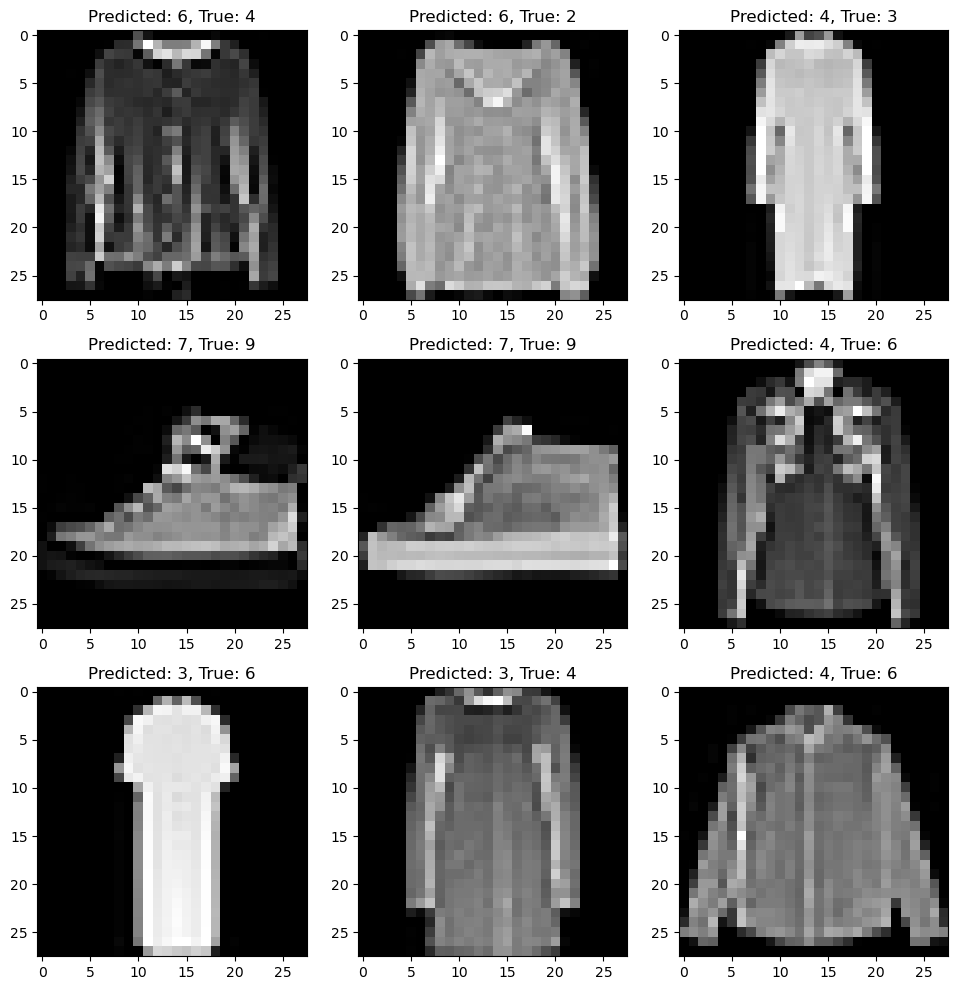

In [47]:
# Load model from local
# model = torch.load('model/MiniVGGNet.pth')

# The correct labels of this data set
label_descriptions = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Printing the label 
print("The true label of the data set are: ")
for label, description in label_descriptions.items():
    print(f"Label: {label}, {description}")

# Evaluate the model
test_and_plot_incorrect(model, test_loader, 10)

### Plot the accuracy and loss for training and testing

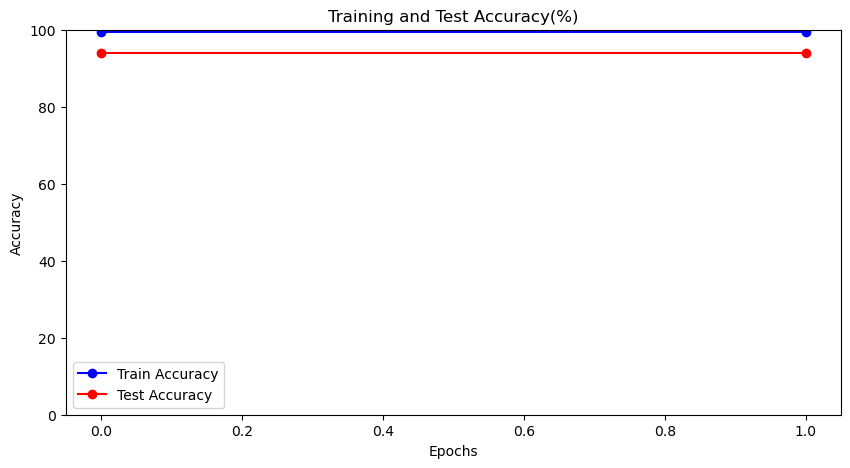

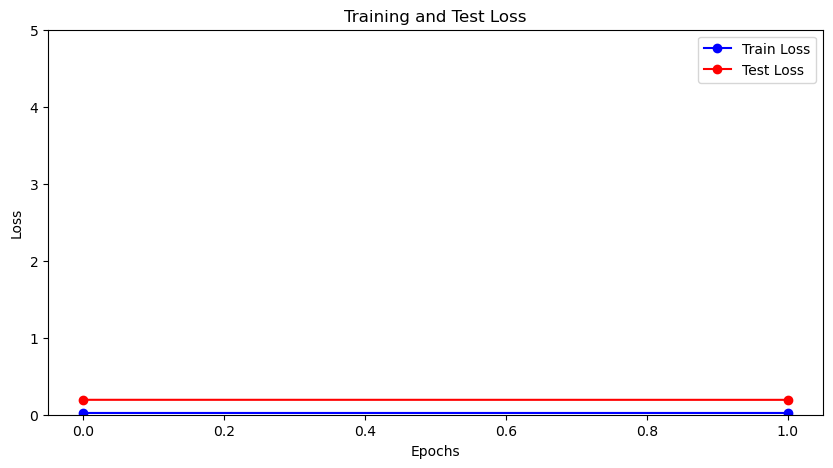

In [50]:
polt_for_train_test(epochs, train_losses, train_accuracies, test_losses, test_accuracies)

### Model Summary

In [ ]:
summary(model, input_shape)